# Diffusion pseudotime on thymocytes

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata2ri
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 5]

sc.settings.set_figure_params(dpi=100, color_map='Blues')

In [15]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

### Import data 

In [6]:
adata_F74_1 = sc.read_10x_mtx('/home/jovyan/my_data/Human_colon_16S7985396/', cache=True)
adata_F74_2 = sc.read_10x_mtx('/home/jovyan/my_data/Human_colon_16S7985397/', cache=True)

In [7]:
## Rename matching annotation in ATAC data
adata_F74_1.obs_names = [i.split('-')[0]+'_1' for i in adata_F74_1.obs_names]
adata_F74_2.obs_names = [i.split('-')[0]+'_2' for i in adata_F74_2.obs_names]

### Preprocessing

Taken from Cecilia's notebook

1. Filter cells with high mitochondrial counts

In [8]:
mito_genes = [name for name in adata_F74_1.var_names if name.startswith('MT-')]
#the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata_F74_1.obs['percent_mito'] = np.sum(adata_F74_1[:, mito_genes].X, axis=1).A1 / np.sum(adata_F74_1.X, axis=1).A1

mito_genes = [name for name in adata_F74_2.var_names if name.startswith('MT-')]
adata_F74_2.obs['percent_mito'] = np.sum(adata_F74_2[:, mito_genes].X, axis=1).A1 / np.sum(adata_F74_2.X, axis=1).A1

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


2. Filter cells w low counts

In [9]:
adata_F74_1.obs['n_counts'] = adata_F74_1.X.sum(axis=1).A1
adata_F74_2.obs['n_counts'] = adata_F74_2.X.sum(axis=1).A1

sc.pp.filter_cells(adata_F74_1, min_genes=600)
sc.pp.filter_cells(adata_F74_1, min_counts=1000)

sc.pp.filter_cells(adata_F74_2, min_genes=600)
sc.pp.filter_cells(adata_F74_2, min_counts=1000)


In [10]:
adata = adata_F74_1.concatenate(adata_F74_2, join='outer',index_unique=None)

3. Normalize

In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

4. Log transform

In [12]:
sc.pp.log1p(adata)
adata.raw = adata

7. Add annotation provided by Cecilia

In [13]:
annotation = pd.read_csv("/home/jovyan/my_data/F74_RNA_obs_v2.csv", index_col=0)
## Rename matching annotation in ATAC data
annotation.index = [annotation.index[i].split("_")[2]+"_1" if annotation.batch.tolist()[i]==0 else annotation.index[i].split("_")[2]+"_2" for i in range(0,len(annotation.index))]

adata.obs = pd.concat([adata.obs,annotation[['anno_v2', 'annotation']]], axis=1, join="outer")


Save data as SingleCellExperiment

In [95]:
%%R -i adata
saveRDS(adata, "~/my_data/F74_RNA_scanpy_preprocessed.RDS")

Load SingleCellExperiment object

In [16]:
%%R -o adata_r
adata_r <- readRDS("/home/jovyan/my_data/integrated_thymus/F74_SCElist_20191113.RDS")[["RNA"]]

#### Visualization

In [17]:
# adata.X = adata.layers["logcounts"]

KeyError: 'logcounts'

5. Select HVGs

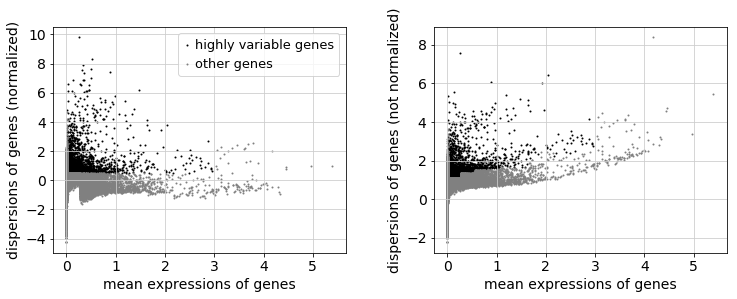

In [20]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

adata_hvg = adata[:, adata.var['highly_variable']]

6. Regress out technical effects

In [103]:
sc.pp.regress_out(adata_hvg, ['n_counts', 'percent_mito'])

In [21]:
adata_hvg.obs = adata_hvg.obs.astype({'annotation':'category'})

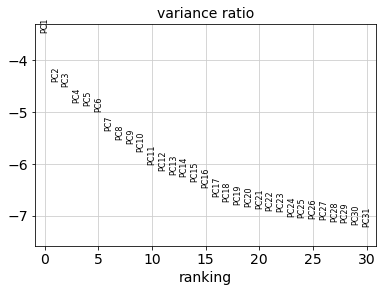

In [22]:
sc.pp.scale(adata_hvg, max_value=10)
sc.tl.pca(adata_hvg)
sc.pl.pca_variance_ratio(adata_hvg, log=True)

In [92]:
sc.pp.neighbors(adata_hvg, n_pcs=40)
sc.tl.umap(adata_hvg)

Clustering with lower resolution (to have less clusters)

In [99]:
sc.tl.leiden(adata_hvg, resolution=0.5)

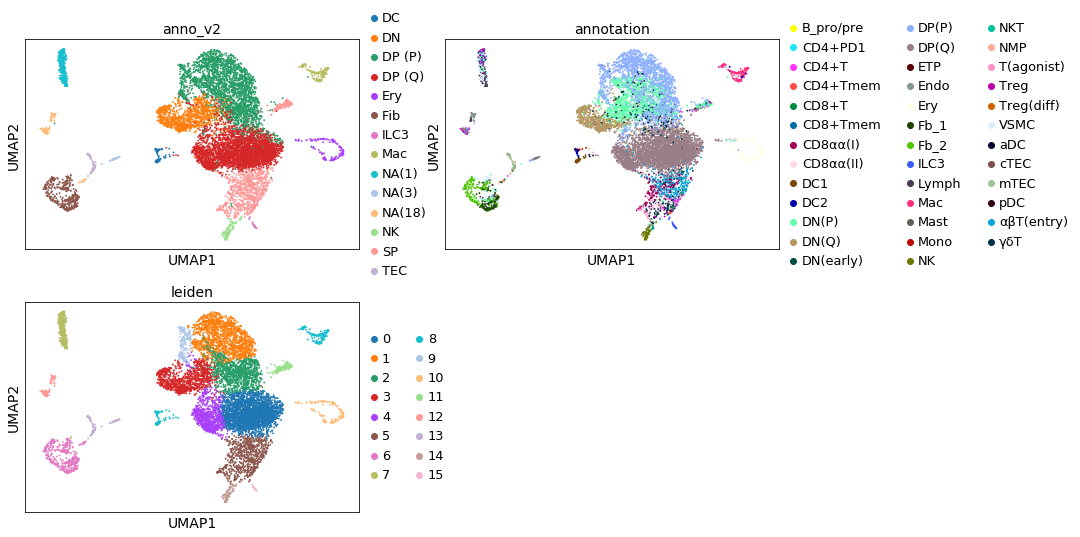

In [100]:
sc.pl.umap(adata_hvg, color=['anno_v2',"annotation" ,"leiden"], ncols=2)

#### Reannotate clusters

Based on V2 but splitting clusters that are separate

In [111]:
annotation.columns = [col + "_cecilia" for col in annotation.columns]

In [115]:
adata_hvg.obs = pd.concat([adata_hvg.obs,annotation[['anno_v2_cecilia', 'leiden_cecilia']]], axis=1, join="outer")

In [143]:
adata_hvg.obs = adata_hvg.obs.astype({'leiden_cecilia':'str'})

... storing 'leiden_cecilia' as categorical


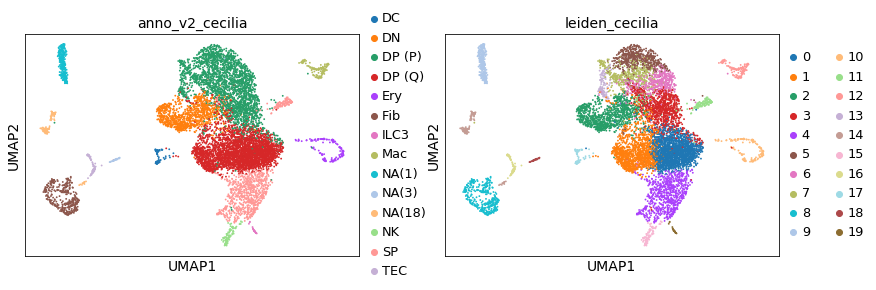

In [144]:
sc.pl.umap(adata_hvg, color=["anno_v2_cecilia", "leiden_cecilia"])

In [145]:
anno_v3 = {'0':'DP (Q)', '1':'DP (Q)', '2':'DN', '3':'DP (P)', '4':'SP (1)', '5':'DP (P)', '6':'DP (P)', 
           '7':'DP (P)', '8':'Fib', '9':'NA(1)' , '10':'Ery', '11':'SP (2)','12':'Mac','13':'DP (P)','14':'NA(18)',
           '15':'NK','16':'TEC','17':'DC','18':'NA(3)','19':'ILC3'}

In [146]:
adata_hvg.obs['anno_v3'] = adata_hvg.obs['leiden_cecilia'].map(anno_v3)

... storing 'anno_v3' as categorical


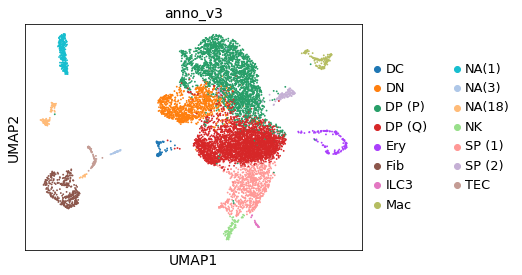

In [147]:
sc.pl.umap(adata_hvg, color="anno_v3")

#### Save AnnData and annotation

In [26]:
results_file = '~/my_data/F74_RNA_scanpy_preprocessed.h5ad'
adata.write(results_file, compression='gzip')  

... storing 'anno_v2' as categorical
... storing 'annotation' as categorical


In [148]:
F74_obs_v3 = adata_hvg.obs
F74_obs_v3.to_csv('/home/jovyan/my_data/F74_RNA_obs_v3.csv')

### PAGA analysis 

Remove cell cycle genes from HVGs

In [158]:
cell_cycle_genes = pd.read_table("/home/jovyan/annotations/cell_cycle_genes.tsv", header=None)

In [170]:
# adata_hvg.var.index[0] in cell_cycle_genes[0]
adata_hvg.var["highly_variable_clean"] = [True if x not in cell_cycle_genes[0] else False for x in adata_hvg.var.index]

In [171]:
# adata = sc.read_h5ad('/home/jovyan/my_data/F74_RNA')
adata_hvg_2 = adata_hvg[:, adata_hvg.var['highly_variable_clean']]

Visualize graph (or is this required 4 PAGA?)

In [172]:
sc.tl.draw_graph(adata_hvg_2)

KeyboardInterrupt: 

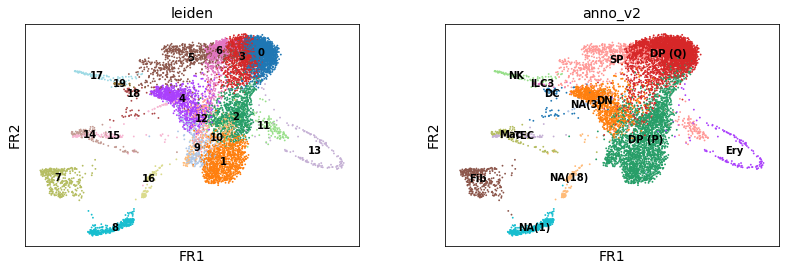

In [32]:
sc.pl.draw_graph(adata_hvg, color=['leiden', 'anno_v2'], legend_loc='on data')

Run PAGA

In [175]:
sc.tl.paga(adata_hvg_2, groups="anno_v3")

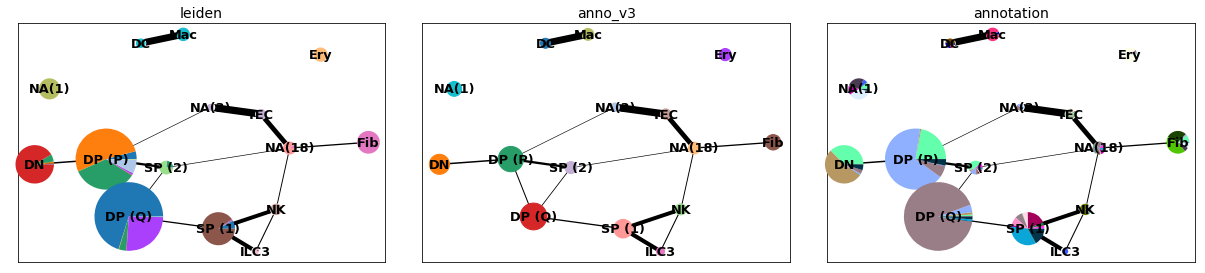

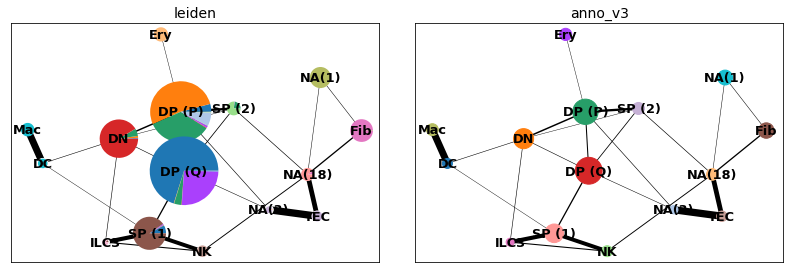

In [177]:
sc.pl.paga(adata_hvg_2, threshold=0.08, color=["leiden", "anno_v3", "annotation"])
sc.pl.paga(adata_hvg_2, threshold=0.05, color=["leiden", "anno_v3"])

Calculate pseudotime starting from selected root cell (the DN T-cells)

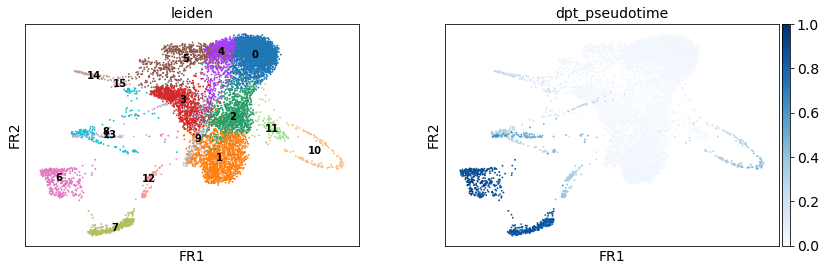

In [179]:
adata_hvg_2.uns["iroot"] = np.flatnonzero(adata_hvg_2.obs["anno_v3"] == 'DN')[0]
sc.tl.dpt(adata_hvg_2)
sc.pl.draw_graph(adata_hvg, color=['leiden', 'dpt_pseudotime'], legend_loc='on data')

#### Restrict to T-cells clusters

In [217]:
tcellsRNA = ["DN", "DP (Q)", "DP (P)", "SP (1)", "SP (2)"]

adataTcells = adata_hvg_2[adata_hvg_2.obs['anno_v3'].isin(tcellsRNA),]
adataTcells.X = adataTcells.X.astype('float64')  # this is not required and results will be comparable without it


In [219]:
# adataTcells[adataTcells.var["highly_variable_clean"]]
adataT_hvg = adataTcells

In [191]:
sc.pp.scale(adataT_hvg)
sc.tl.pca(adataT_hvg)

/home/jovyan/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [192]:
sc.pp.neighbors(adataT_hvg, n_pcs=40)
sc.tl.umap(adataT_hvg)
sc.tl.leiden(adataT_hvg)

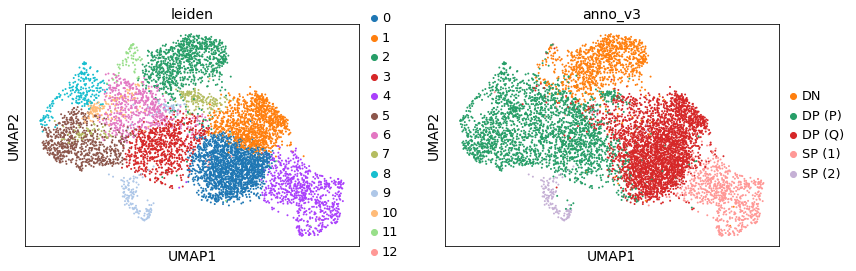

In [193]:
sc.pl.umap(adataT_hvg, color=["leiden", "anno_v3"])

Run PAGA

In [198]:
sc.tl.paga(adataT_hvg, groups="leiden")

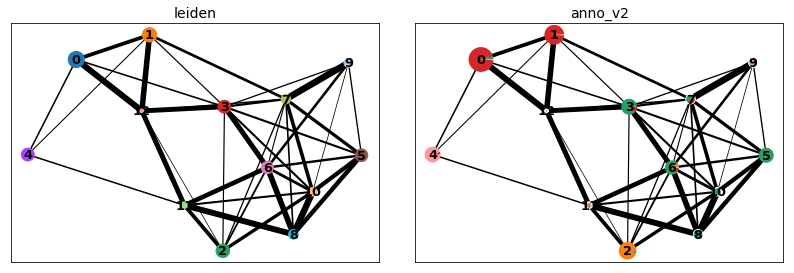

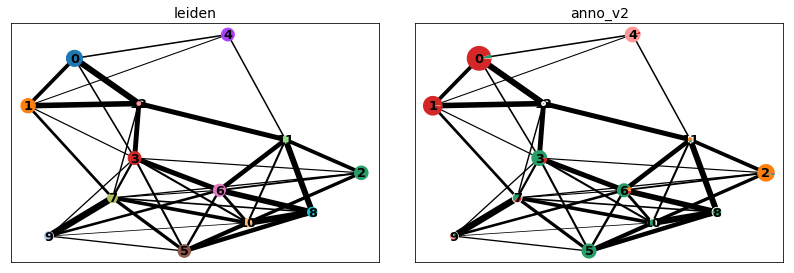

In [199]:
sc.pl.paga(adataT_hvg, threshold=0.08, color=["leiden", "anno_v2"])
sc.pl.paga(adataT_hvg, threshold=0.1, color=["leiden", "anno_v2"])

Pseudotime analysis

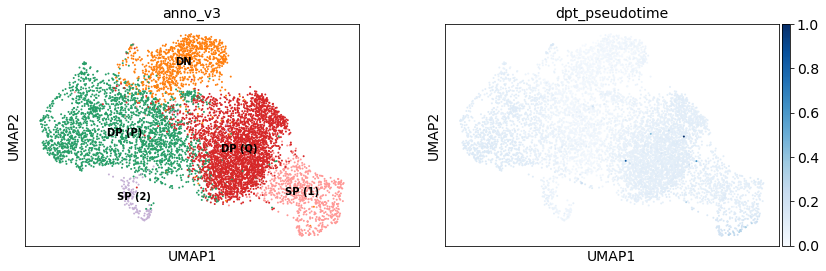

In [202]:
adataT_hvg.uns["iroot"] = np.flatnonzero(adataT_hvg.obs["anno_v3"] == 'DN')[0]
sc.tl.dpt(adataT_hvg)
sc.pl.umap(adataT_hvg, color=['anno_v3', 'dpt_pseudotime'], legend_loc='on data')

Remove pseudotime outliers

In [210]:
adataT = adataT_hvg[adataT_hvg.obs.dpt_pseudotime < 0.4]

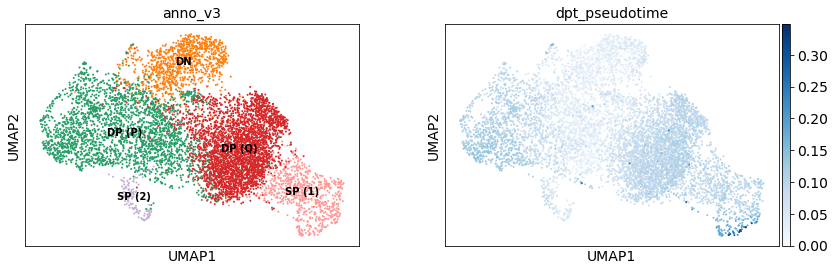

In [211]:
sc.pl.umap(adataT, color=['anno_v3', 'dpt_pseudotime'], legend_loc='on data')

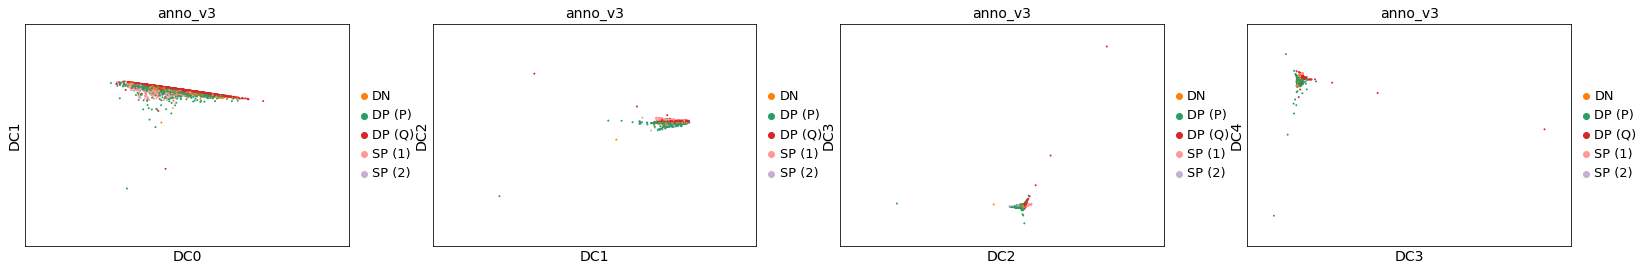

In [213]:
sc.pl.diffmap(adataT_hvg, color=["anno_v3"], components=['0,1', '1,2', '2,3', "3,4"])

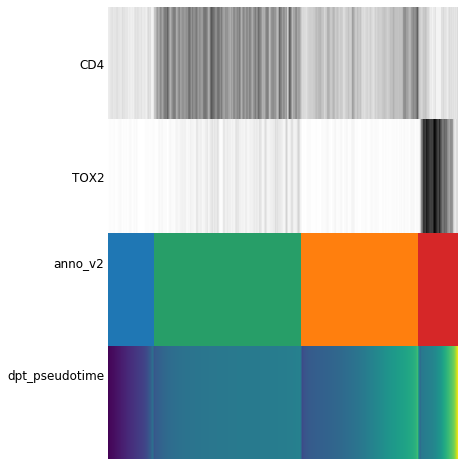

In [88]:
sc.pl.paga_path(adataT_hvg, ["DN", "DP (Q)", "DP (P)", "SP"], ["CD4", "TOX2"],
               show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['dpt_pseudotime'],
        show_colorbar=False,
        color_map='Greys',
        groups_key='anno_v2',
        color_maps_annotations={'dpt_pseudotime': 'viridis'})

### Trajectory analysis on T-cells

Using diffusion pseudotime (as in JPs paper)

Subset to T-cell clusters

In [370]:
# tcellsATAC = range(1,6)
tcellsRNA = ["DN", "DP (Q)", "DP (P)", "SP"]

adataTcells = adata[adata.obs['anno_v2'].isin(tcellsRNA),]

Calculate neighborhoods

In [220]:
sc.pp.neighbors(adataTcells, n_neighbors=10, method="gauss", knn=False)

Run diffusion map algorithm 

In [221]:
sc.tl.diffmap(adataTcells)

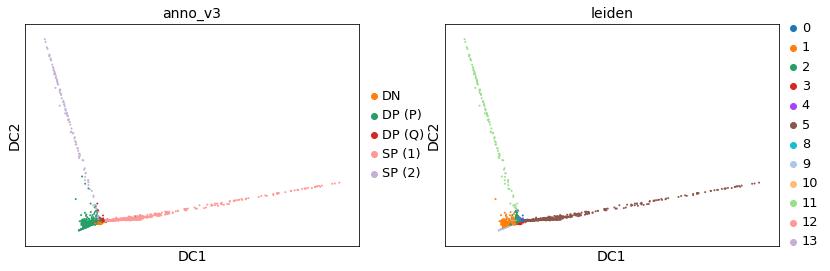

In [223]:
sc.pl.diffmap(adataTcells, color=["anno_v3", "leiden"])

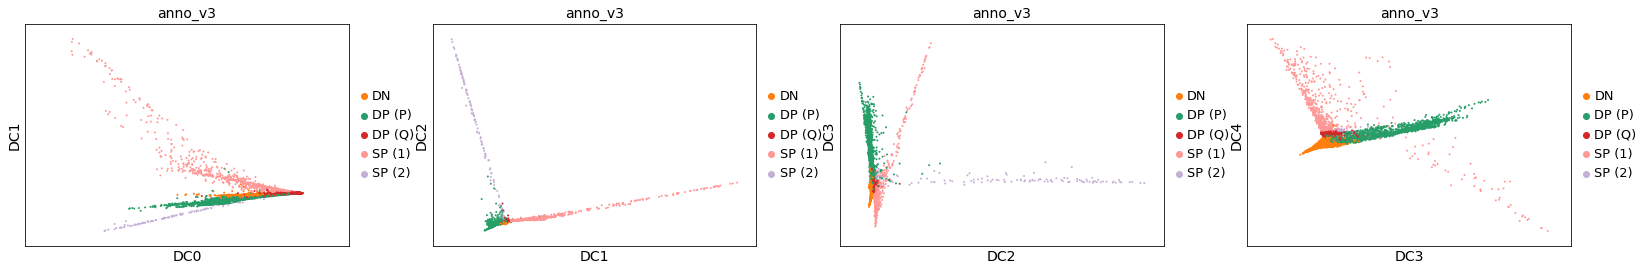

In [224]:
sc.pl.diffmap(adataTcells, color=["anno_v3"], components=['0,1', '1,2', '2,3', "3,4"])

Find root cell among the Double Negatives

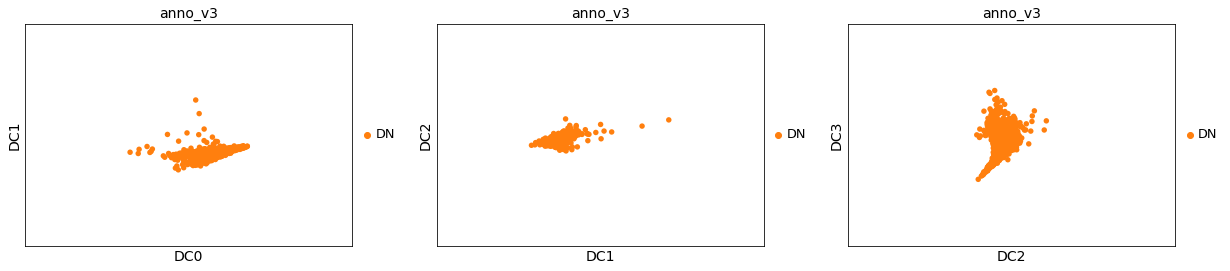

In [225]:
sc.pl.diffmap(adataTcells[adataTcells.obs.anno_v2=="DN"], color=["anno_v3"], components=['0,1', '1,2', '2,3'])

In [226]:
DN_diffmap = adataTcells[adataTcells.obs.anno_v2=="DN"].obsm["X_diffmap"]

iroot = np.where(DN_diffmap[:,[1]] == np.amin(DN_diffmap[:,[1]]))[0][0]
root = adataTcells.obs.iloc[iroot].name

In [227]:
adataTcells.var['xroot'] = adataTcells[root, :].X

/home/jovyan/.local/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


Run pseudotime

In [228]:
sc.tl.dpt(adataTcells, n_branchings=0, n_dcs=4)

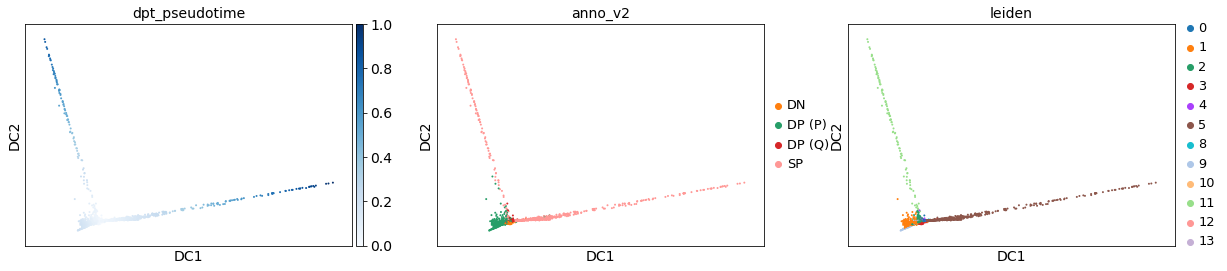

In [229]:
sc.pl.diffmap(adataTcells, color=["dpt_pseudotime",'anno_v2', 'leiden'])

In [234]:
sc.pp.neighbors(adataTcells, knn=True)
sc.tl.umap(adataTcells)

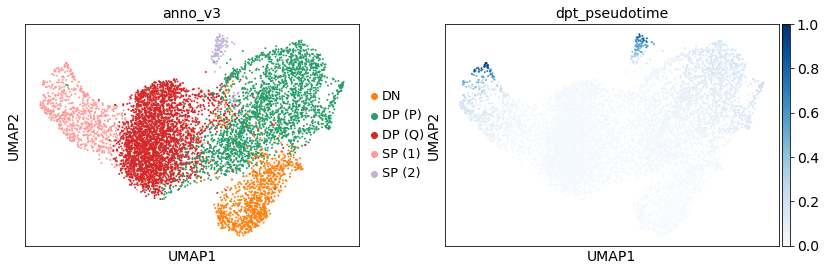

In [235]:
sc.pl.umap(adataTcells, color=["anno_v3","dpt_pseudotime"])

Save diffusion pseudotime 

In [236]:
adataTcells.obs.to_csv("/home/jovyan/models/scanpy_RNA_pseudotime.csv")